# Read saved data

In [1]:
import os
from scipy.sparse import load_npz
import numpy as np
from datetime import datetime, timedelta
import time
import numpy as np
from numba import njit, prange

In [2]:
def get_dates():
    # Define the start and end dates
    start_date = datetime(2025, 1, 2)
    end_date = datetime(2025, 7, 1)

    # Generate a list of dates excluding weekends
    date_list = []
    current_date = start_date
    while current_date <= end_date:
        if current_date.weekday() < 5:  # Monday = 0, Sunday = 6
            date_list.append(current_date)
        current_date += timedelta(days=1)

    date_list = [date.strftime("%Y-%m-%d") for date in date_list]
    holidays = ["2025-04-18","2025-04-21", "2025-05-05", "2025-05-26"]
    for h in holidays:
        date_list.remove(h)

    print(len(date_list), "days between", date_list[0], date_list[-1])
    return date_list

In [3]:
def readc_day(day: str):
    folder = "CSR_Data"
    lob_data = load_npz(os.path.join(folder,"CSR_LOB_"+day+".npz")).toarray()
    lob_times = np.load(os.path.join(folder, "TIM_LOB_"+day+".npy"))
    tapes = np.load(os.path.join(folder, "TAP_"+day+".npy"))
    return lob_data, lob_times, tapes

def get_data(min_n = 0, max_n = 125):
    s = time.time()
    date_list = get_dates()
    all_data = []

    for day in date_list[min_n:max_n]:
        data = readc_day(day)
        all_data.append(data)

    print("Time taken to reach each day:", (time.time() - s) / (max_n - min_n))

    return all_data

data = get_data(0,2)
len(data)

125 days between 2025-01-02 2025-07-01
Time taken to reach each day: 0.23119664192199707


2

# Generate Features

In [4]:
@njit(parallel=True)
def get_features(lob_data: np.array, 
                 lob_times: np.array, 
                 tapes: np.array, 
                 time_step_s: int, 
                 ab_weight = 1, 
                 median = False, 
                 cas_cbs_window = 800):
    
    
    n_rows = int((8.5 * 60 * 60) / time_step_s)                         # define number of rows of output array
    features = ["MP","VOL","HIBID","LOASK","SPREAD","AP",               # define features
                "TCBS","TCAS","WBP","WAP","AWS",
                "ALPHA", "BETA", "ZETA", "GAP"]
    n_features = len(features)                                          # define number of features

    feat_arr = np.zeros((n_rows, n_features), dtype=np.float64)         # array to hold feature values
    time_arr = np.arange(0,(8.5*60*60), time_step_s) + time_step_s      # array to hold timestamps, this
                                                                        # is always the end of the segment
    
    LA_HB_a_b = np.zeros((lob_data.shape[0]+1, 4), dtype = np.float64)  # array holding the LOASK, HIBID,
                                                                        # alpha, beta, values 

    for i in prange(lob_data.shape[0]):                                 # iterates over the LOB to fill
        row = lob_data[i]                                               # LA_HB_a_b values
        
        neg_ind = np.where(row < 0)[0]                                  # locate bid and ask prices (indicies)
        pos_ind = np.where(row > 0)[0]
        
        if len(neg_ind) == 0:                                           # assign HIBID, np.nan if no values
            LA_HB_a_b[i][1] = np.nan
        else:
            LA_HB_a_b[i][1] = max(neg_ind) + 1 

        if len(pos_ind) == 0:                                           # assign HIBID, np.nan if no values
            LA_HB_a_b[i][0] = np.nan
        else:
            LA_HB_a_b[i][0] = min(pos_ind) + 1

        mid_price = (LA_HB_a_b[i][0] + LA_HB_a_b[i][1]) / 2             # calculate mid_price for alpha/beta calculations

        if np.isnan(mid_price):
            alpha = np.nan
            beta = np.nan
        else:                                                           # calculate alpha/beta using ab_weight var
            beta = 0
            for ind in neg_ind:
                beta += (-1 * row[ind]) / ((mid_price - (ind + 1)) + ab_weight)
    
            alpha = 0
            for ind in pos_ind:
                alpha += row[ind] / (((ind + 1) - mid_price) + ab_weight)
                

        LA_HB_a_b[i][2] = alpha
        LA_HB_a_b[i][3] = beta
        
    max_lob = lob_data.shape[0] - 1                                      # define max indicies for lob
    max_tapes = tapes.shape[0] - 1                                       # define max indicies for tapes
    
    start_time = 0                                                       # define start time
    lob_start = 0                                                        # define start index for lob
    tapes_start = 0                                                      # define start index for tapes
    
    cas = np.zeros(800, dtype = np.int16)                                # define an array to hold CAS values
    cbs = np.zeros(800, dtype = np.int16)                                # define an array to hold CBS values
    for row_i in range(n_rows):
        end_time = start_time + time_step_s                              # move to next time step
        lob_end = lob_start
        tapes_end = tapes_start

        # get lob slice
        while lob_times[lob_end] < end_time and lob_end < max_lob:       # move lob indicies to end time
            lob_end += 1
        
        # get tapes slice
        while tapes[tapes_end][0] < end_time and tapes_end < max_tapes:  # move tapes indicies to end time
            tapes_end += 1

        # feature calculations
        if tapes_start == tapes_end:                                     # if there is no tapes data
            AP = np.nan                                                  # set tapes features to np.nan
            VOL = np.nan
        else:
            tapes_slice = tapes[tapes_start:tapes_end]                   # extract tapes slice, calculate AP, VOL
            AP = np.nanmean(tapes_slice[:,1])
            VOL = np.sum(tapes_slice[:,2])

        if lob_start == lob_end:                                         # if there is no LOB data
            MP = np.nan                                                  # set lob features to np.nan
            HIBID = np.nan
            LOASK = np.nan
            SPREAD = np.nan
            TCBS = np.nan
            TCAS = np.nan
            WBP = np.nan
            WAP = np.nan
            AWS = np.nan
            ALPHA = np.nan
            BETA = np.nan
            ZETA = np.nan  
        else:
            lob_slice = lob_data[lob_start:lob_end]                       # extract slices of data 
            LA_HB_a_b_slice = LA_HB_a_b[lob_start:lob_end]                

            # midprice_calcs, alpha, beta
            if median:                                                    # calculate price features
                HIBID = np.median(LA_HB_a_b_slice[:,1])                   # using median if set to true
                LOASK = np.median(LA_HB_a_b_slice[:,0])
                ALPHA = np.median(LA_HB_a_b_slice[:,2])
                BETA = np.median(LA_HB_a_b_slice[:,3])
            else:
                HIBID = np.nanmean(LA_HB_a_b_slice[:,1])
                LOASK = np.nanmean(LA_HB_a_b_slice[:,0])
                ALPHA = np.nanmean(LA_HB_a_b_slice[:,2])
                BETA = np.nanmean(LA_HB_a_b_slice[:,3])

            MP = (HIBID + LOASK) / 2
            SPREAD = LOASK - HIBID
            ZETA = BETA - ALPHA

            if HIBID >= LOASK:
                print("WARNING: HIBID >= LOASK")

            # consolidated calcs
            cas[:] = 0                                                      # reset cas, cbs arrays for new data
            cbs[:] = 0 
            idx_MP = int(MP - 1)                                            # calculate index for mid_price
            for ci in prange(800):
                # can optimise with LOASK AND HIBID here
                p = ci + 1

                if p <= LOASK + 100 and p >= idx_MP - cas_cbs_window:       # only calculate cbs between window given
                    cbs_vec = lob_slice[:,ci].copy() * -1                   # and between LOASK + 100 for efficiency
                    cbs_vec[cbs_vec <= 0] = 0                               # idk if this breaks things for efficiency ?:
                    cbs[ci] = np.sum(np.abs(np.diff(cbs_vec))) + cbs_vec[0]

                if p >= HIBID - 100 and p <= idx_MP + cas_cbs_window:       # only calculate cas between window given
                    cas_vec = lob_slice[:,ci].copy()                        # and between HIBID - 100 for efficiency
                    cas_vec[cas_vec <= 0] = 0                               # idk if this breaks things for efficiency ?:
                    cas[ci] = np.sum(np.abs(np.diff(cas_vec))) + cas_vec[0]

            TCBS = np.sum(cbs)                                              # Total CBS
            TCAS = np.sum(cas)                                              # Total CAS

            if TCBS == 0:                                                   # Calculate WBP, np.nan if no activity
                WBP = np.nan
            else:
                WBP = 0
                for ci in prange(800):
                    WBP += (ci + 1) * (cbs[ci] / TCBS)

            if TCAS == 0:                                                   # Calculate WAP, np.nan if no activity
                WAP = np.nan
            else:
                WAP = 0
                for ci in prange(800):
                    WAP += (ci + 1) * (cas[ci] / TCAS)

            AWS = WAP - WBP                                                 # Activity weighted spread calc
        

        # feature setting

        feat_arr[row_i][features.index("AP")] = AP
        feat_arr[row_i][features.index("VOL")] = VOL
        feat_arr[row_i][features.index("MP")] = MP
        feat_arr[row_i][features.index("HIBID")] = HIBID
        feat_arr[row_i][features.index("LOASK")] = LOASK
        feat_arr[row_i][features.index("SPREAD")] = SPREAD
        feat_arr[row_i][features.index("TCAS")] = TCAS
        feat_arr[row_i][features.index("TCBS")] = TCBS
        feat_arr[row_i][features.index("WAP")] = WAP
        feat_arr[row_i][features.index("WBP")] = WBP
        feat_arr[row_i][features.index("AWS")] = AWS
        feat_arr[row_i][features.index("ALPHA")] = ALPHA
        feat_arr[row_i][features.index("BETA")] = BETA
        feat_arr[row_i][features.index("ZETA")] = ZETA
        feat_arr[row_i][features.index("GAP")] = MP - AP

        # adjust start times
        start_time = end_time                                                # Set the next start times and 
        lob_start = lob_end                                                  # indicies to the last end times / indicies
        tapes_start = tapes_end

    return feat_arr, time_arr, features

feat_arr = get_features(data[0][0],data[0][1],data[0][2],60, cas_cbs_window = 50)
s = time.time()
feat_arr, time_arr, feats = get_features(data[1][0],data[1][1],data[1][2], 60, cas_cbs_window = 50)
print(time.time() - s)
feat_arr

Max time:  30600.0
Max time:  30600.0
2.869980812072754


array([[2.77906529e+02, 8.10000000e+01, 2.67265625e+02, ...,
        1.55246121e+00, 1.84441981e+00, 2.91958605e-01],
       [2.87103306e+02, 7.80000000e+01, 2.84677686e+02, ...,
        1.97822111e+00, 2.99543735e+00, 1.01721623e+00],
       [2.93990264e+02, 6.60000000e+01, 2.90980529e+02, ...,
        1.84533032e+00, 3.55182573e+00, 1.70649540e+00],
       ...,
       [2.94500000e+02, 1.00000000e+02, 2.83062193e+02, ...,
        1.00946354e+00, 3.33102017e+00, 2.32155663e+00],
       [2.96658247e+02, 1.17000000e+02, 2.77665676e+02, ...,
        1.16017913e+00, 2.18982138e+00, 1.02964225e+00],
       [3.14226796e+02, 1.08000000e+02, 2.87744012e+02, ...,
        6.41379369e-01, 1.45374816e+00, 8.12368794e-01]])

# Convert to DF

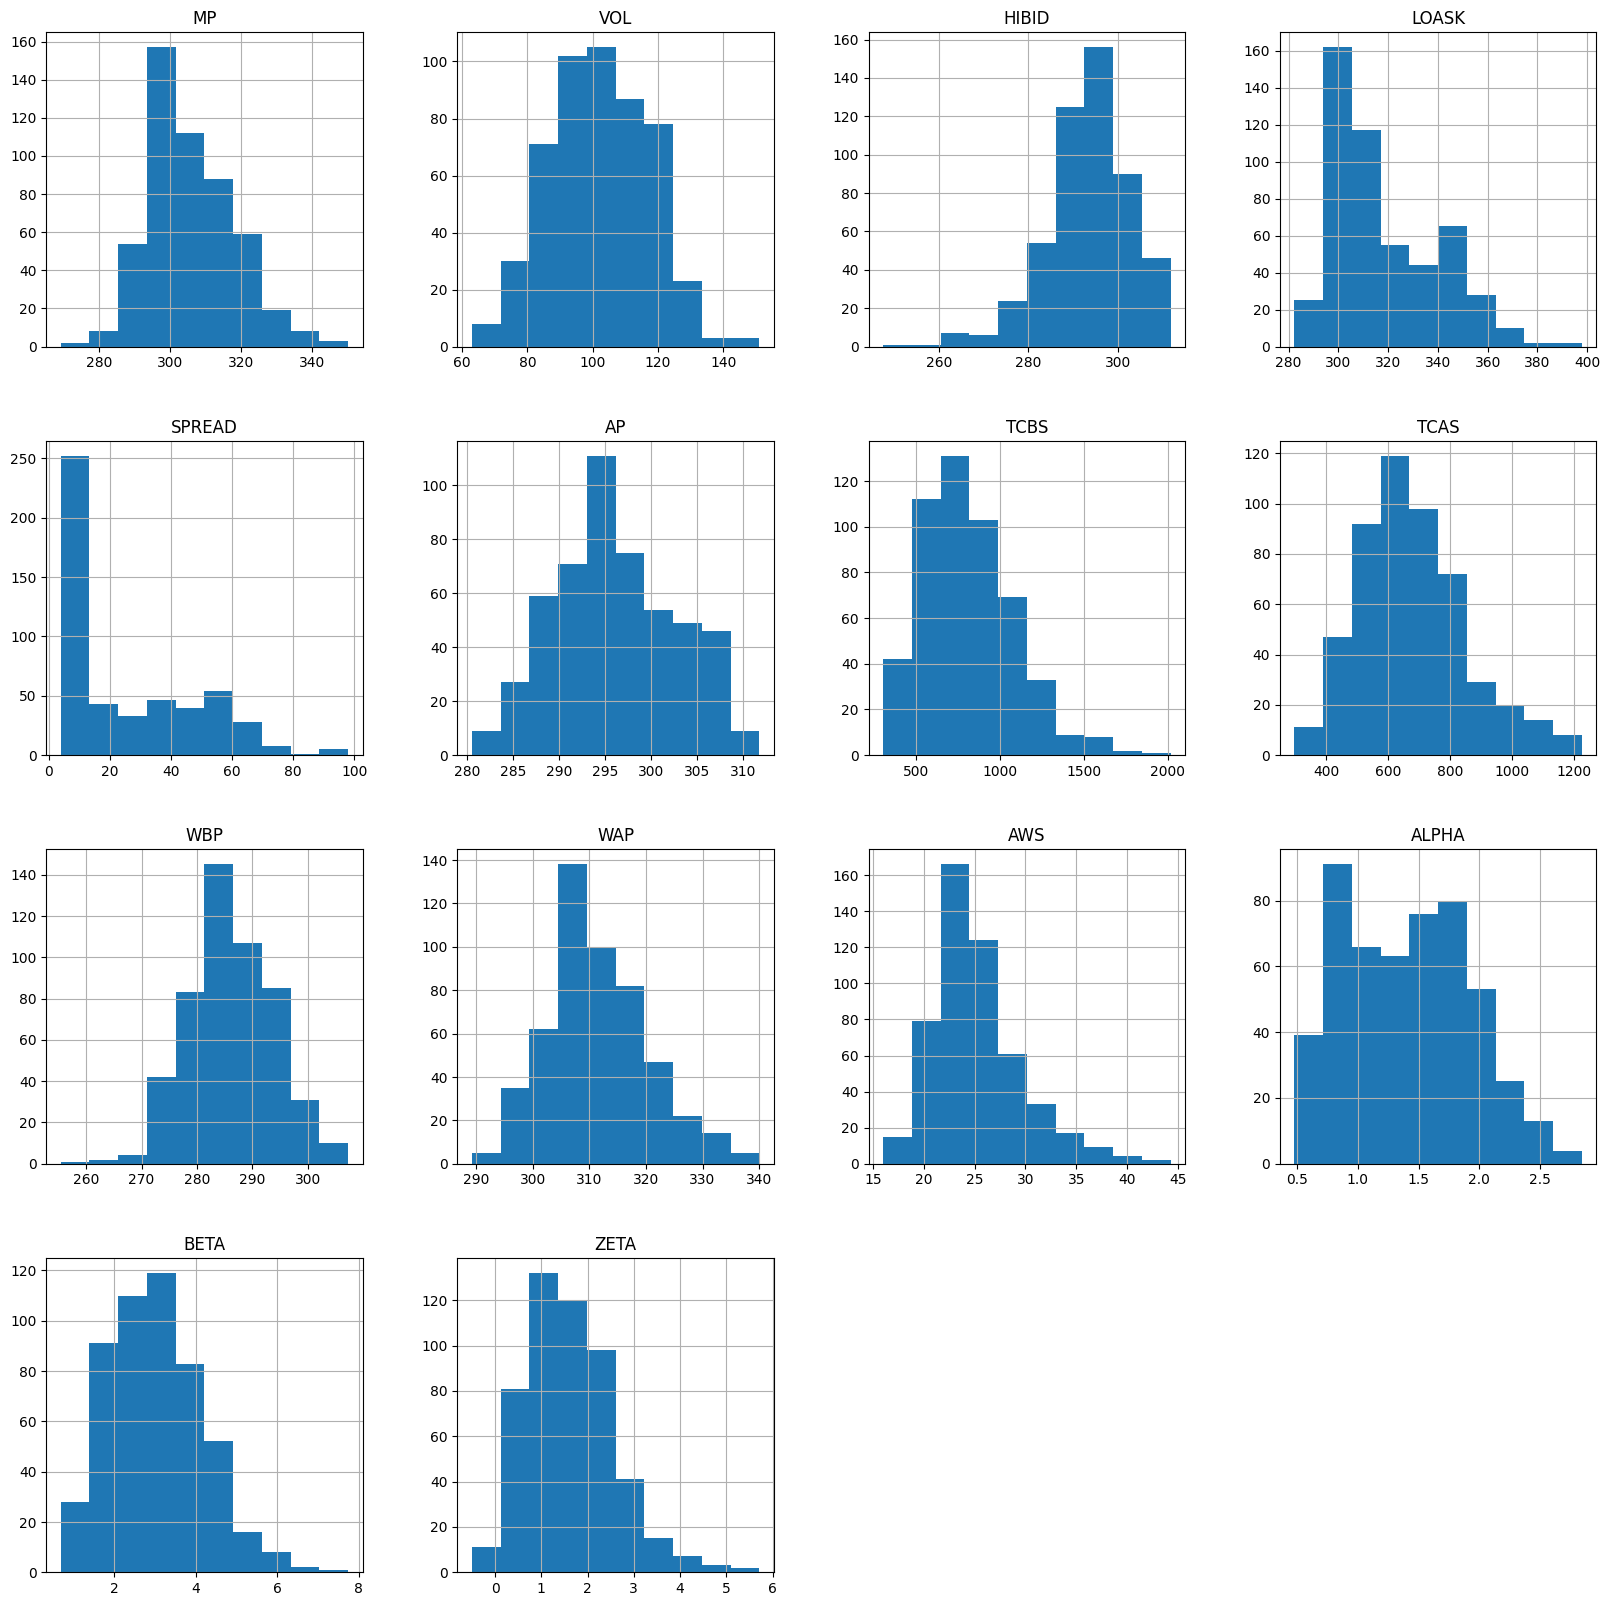

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming feat_arr is your data and feats is a list of column names
df = pd.DataFrame(feat_arr, columns=feats)
#df["ALPHA/VOL"] = df["ALPHA"] / df["VOL"]
#df["BETA/VOL"] = df["BETA"] / df["VOL"]
#df["ZETA/VOL"] = df["ZETA"] / df["VOL"]
df.hist(figsize = (20,20))
plt.show()

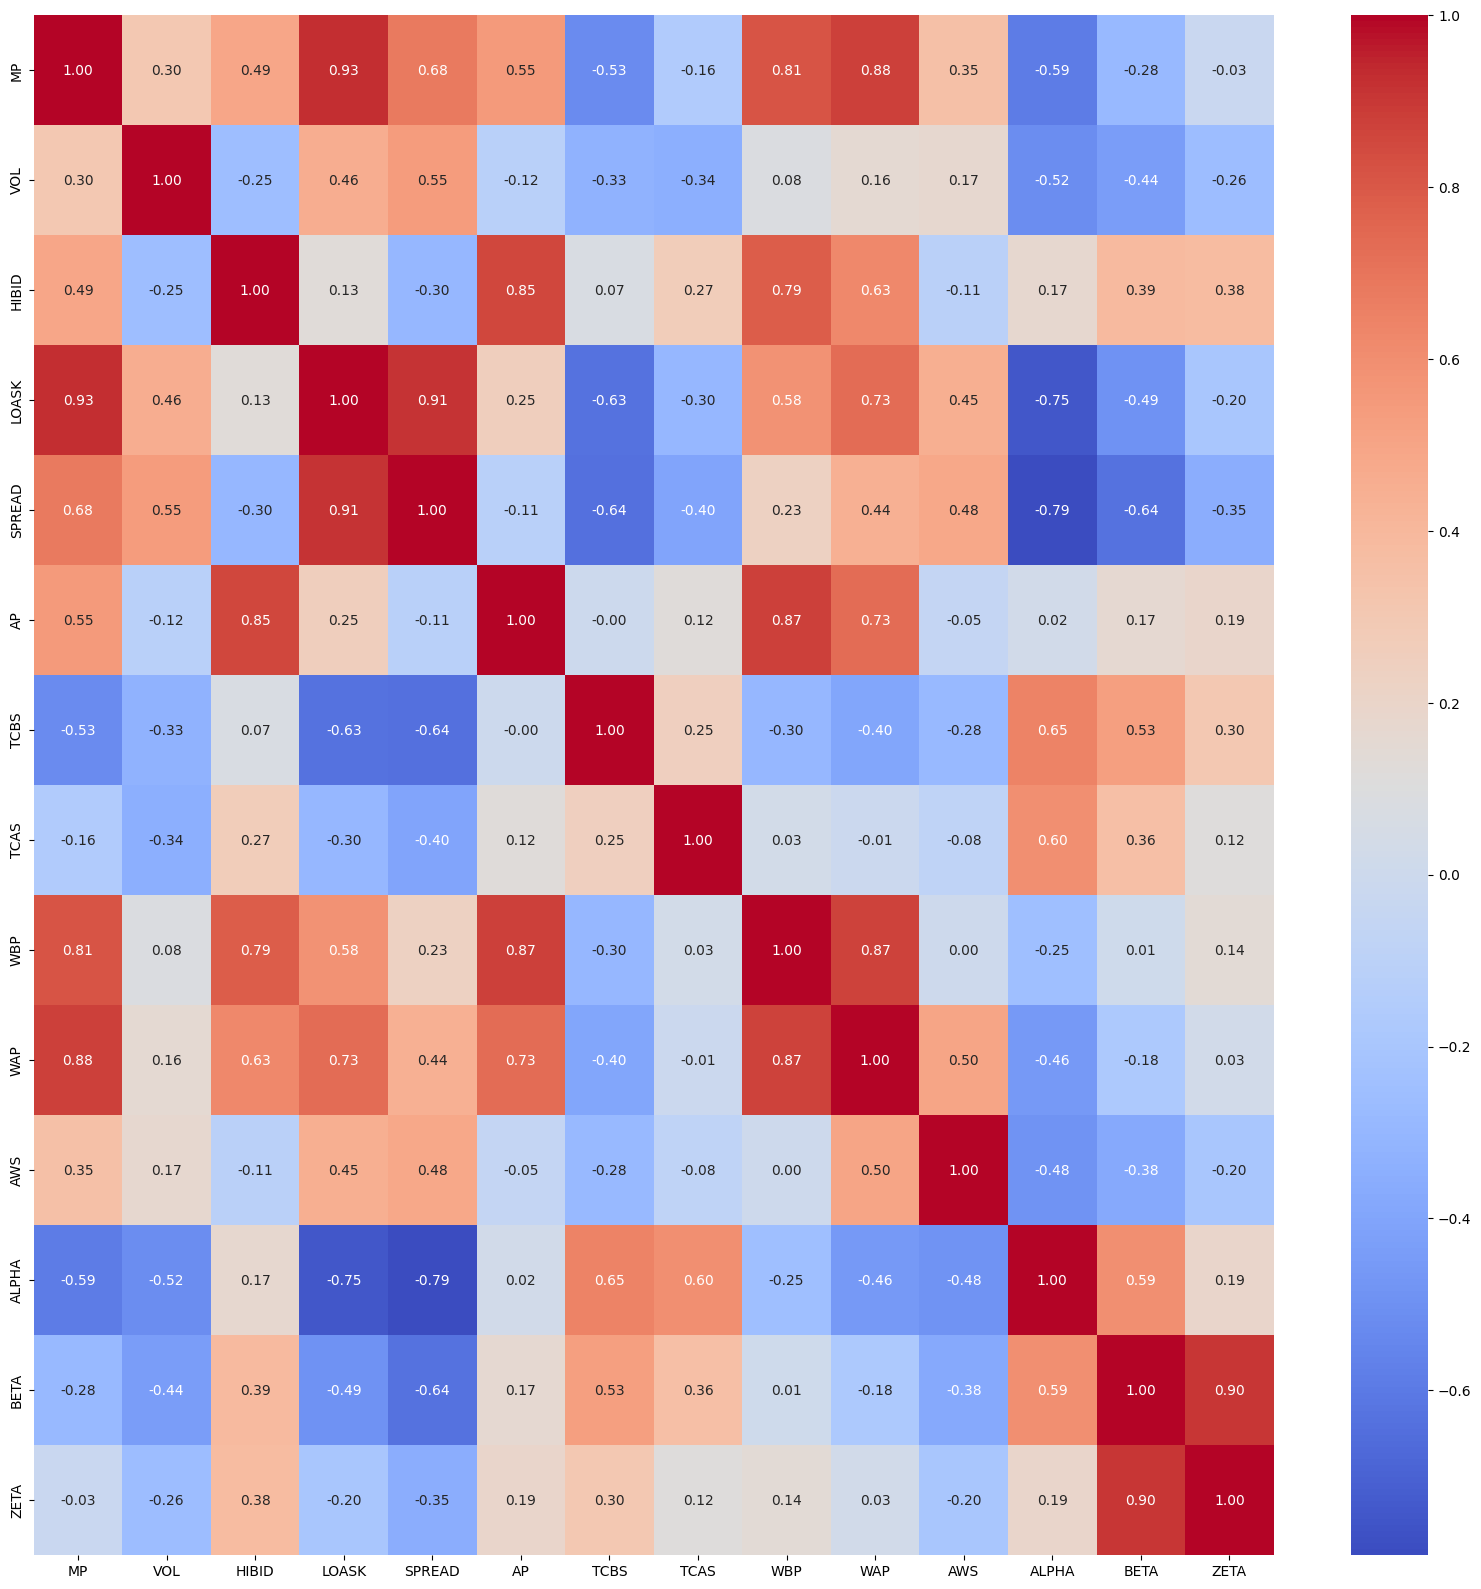

In [10]:
import seaborn as sns

plt.figure(figsize = (20,20))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

# do not run

# writing time index for LOB

from numba import njit, prange
import os
from tools import read_csr, get_Tapes


#@njit(parallel=True)
def get_times_s(raw_lob: list[str]):
    n = len(raw_lob)
    times = np.zeros(n)

    for i in range(n):
        times[i] = float(raw_lob[i].split(",")[0][1:])
    
    return times


def run_box():
    LOB_filename = os.listdir("Data\LOBs")
    for filename in LOB_filename:
        with open(f"Data\LOBs\{filename}", 'r') as f:
            raw_lob = f.readlines()

        times = get_times_s(raw_lob)
        save_name = f"CSR_Data\TIM_LOB_{filename.split('L')[0].split('_')[2]}.npy"
        print(save_name)
        np.save(save_name, times)

# run_box()

# writing tapes data

import pandas as pd

def run_box():
    Tapes_filenames = os.listdir("Data\Tapes")
    for filename in Tapes_filenames:
        tapes = pd.read_csv(f"Data\Tapes\{filename}")
        np_tapes = tapes.to_numpy()
        print(filename)
        np.save(f"CSR_Data\TAP_{filename.split('ta')[0].split('_')[2]}.npy", np_tapes)

#run_box()